In [1]:
import numpy as np
import matplotlib.pyplot as plt
import statistics as stats
from matplotlib.colors import ListedColormap

In [2]:
class MarketSimulator2D_CA:
    def __init__(self, grid_size):
        self.grid_size = grid_size
        
        self.BUY = 1
        self.HOLD = 0
        self.SELL = -1
        
        self.STATES = [self.BUY, self.HOLD, self.SELL]

        self.grid = self.create_random_grid()
        
        self.history = {"buy":[], "hold":[], "sell":[]}

    def create_random_grid(self):
        """Creates and returns a grid with a random initial state."""
        return np.random.choice(self.STATES, size=(self.grid_size, self.grid_size))
    
    def create_symmetric_grid(self):

        grid = np.full((self.grid_size, self.grid_size), self.SELL, dtype=int)
        
        # Center of the grid
        center = self.grid_size // 2
        bound_hold = int(center // 1.6)
        bound_buy = int(center//2.6)


        # Outer square (Hold)
        hold_start = center - (bound_hold-1) 
        hold_end = center + bound_hold
        grid[hold_start:hold_end, hold_start:hold_end] = self.HOLD
        
        # Inner square (Buy)
        buy_start = center - (bound_buy-1) # approx 17x17
        buy_end = center + bound_buy
        grid[buy_start:buy_end, buy_start:buy_end] = self.BUY
        
        self.grid = grid

    def get_majority_neighbor_state(self, grid, i, j):
        """
        Calculates the majority state among the 8 Moore neighbors of cell (i, j).
        Uses the provided grid and periodic boundary conditions.
        """
        size = grid.shape[0]
        neighbor_states = []
        for di in [-1, 0, 1]:
            for dj in [-1, 0, 1]:
                if di == 0 and dj == 0:
                    continue

                ni, nj = (i + di) % size, (j + dj) % size
                neighbor_states.append(grid[ni, nj])

        buy_count = neighbor_states.count(self.BUY)
        hold_count = neighbor_states.count(self.HOLD)
        sell_count = neighbor_states.count(self.SELL)


        if buy_count > hold_count and buy_count > sell_count:
            return self.BUY
        elif sell_count > buy_count and sell_count > hold_count:
            return self.SELL

        else:
            return self.HOLD

    def get_transition_probabilities(self, majority_state, P, Mf, macro_info): 
        """Calculates transition probabilities based on Table 1 from the paper."""
        probs = [0.0, 0.0, 0.0] # [prob_buy, prob_hold, prob_sell]

        if macro_info == "positive":
            if majority_state == self.BUY:
                probs = [P + Mf, (1 - P - Mf) * 0.5, (1 - P - Mf) * 0.5]
            elif majority_state == self.HOLD:
                probs = [(1 - P) * (0.5 + 0.5 * Mf), P, (1 - P) * (0.5 - 0.5 * Mf)]
            elif majority_state == self.SELL:
                probs = [(1 - P) * (0.5 + 0.5 * Mf), (1 - P) * (0.5 - 0.5 * Mf), P]
        
        elif macro_info == "negative":
            if majority_state == self.BUY:
                probs = [P, (1 - P) * (0.5 + 0.5 * Mf), (1 - P) * (0.5 - 0.5 * Mf)]
            elif majority_state == self.HOLD:
                probs = [(1 - P) * (0.5 - 0.5 * Mf), P, (1 - P) * (0.5 + 0.5 * Mf)]
            elif majority_state == self.SELL:
                probs = [(1 - P + Mf) * 0.5, (1 - P + Mf) * 0.5, P - Mf]

        elif macro_info == 'none':
            if majority_state == self.BUY:
                probs = [P, (1 - P) * 0.5, (1 - P) * 0.5]
            elif majority_state == self.HOLD:
                probs = [(1 - P) * 0.5, P, (1 - P) * 0.5]
            elif majority_state == self.SELL:
                probs = [(1 - P) * 0.5, (1 - P) * 0.5, P]

        clipped_probs = np.clip(probs, 0, 1)
        prob_sum = np.sum(clipped_probs)
        if prob_sum == 0:
            return [1/3, 1/3, 1/3]

        normalized_probs = clipped_probs / prob_sum
        prob_dict = {self.BUY: normalized_probs[0], self.HOLD: normalized_probs[1], self.SELL: normalized_probs[2]}
        
        return [prob_dict[state] for state in self.STATES]
    

    def update_grid(self, current_grid, P, Mf, macro_info):
        """Computes the next state of the entire grid based on the current_grid."""
        size = current_grid.shape[0]
        new_grid = np.zeros_like(current_grid)

        for i in range(self.grid_size):
            for j in range(self.grid_size):

                majority = self.get_majority_neighbor_state(current_grid, i, j)
                probs = self.get_transition_probabilities(majority, P, Mf, macro_info)

                new_grid[i, j] = np.random.choice(self.STATES, p=probs)
        
        return new_grid
    
    def run_simulation(self, num_steps, P, Mf, macro_info):

 
        grid = self.grid.copy()

        self.history = {"buy":[], "hold":[], "sell":[]}

        for step in range(num_steps):
            self.history["buy"].append(np.sum(grid == self.BUY))
            self.history["hold"].append(np.sum(grid == self.HOLD))
            self.history["sell"].append(np.sum(grid == self.SELL))  

            grid = self.update_grid(grid, P, Mf, macro_info)

        self.grid = grid

    def plot_grid(self, title=None):
        cmap = ListedColormap(['red', 'lightgray', 'green'])
        bounds = [-1.5, -0.5, 0.5, 1.5]
        norm = plt.matplotlib.colors.BoundaryNorm(bounds, cmap.N)

        plt.imshow(self.grid, cmap=cmap, norm=norm)
        plt.title(title if title else "Final Grid State")
        plt.xticks([])
        plt.yticks([])
        plt.show()

    def plot_hist(self, title=None):
        plt.figure(figsize=(10, 6))
        plt.plot(self.history["buy"], label="Buy", color='green')
        plt.plot(self.history["hold"], label="Hold", color='gray', linestyle='--')
        plt.plot(self.history["sell"], label="Sell", color='red')        

        plt.xlabel('Time Step')
        plt.ylabel('Number of Investors')
        plt.title(title if title else "Investment Behavior Over Time")
        plt.legend()
        plt.show()


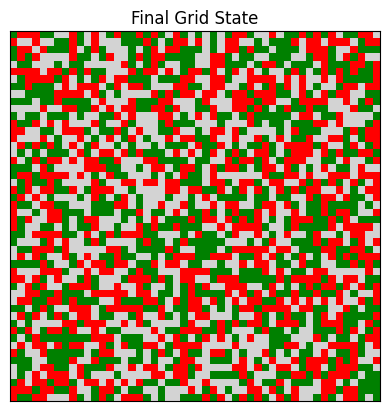

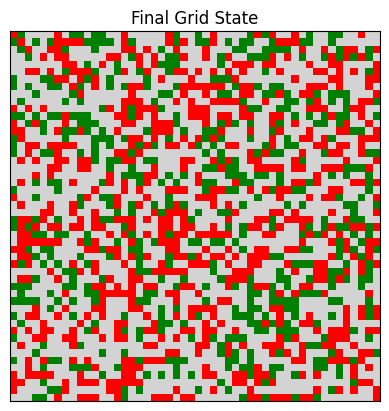

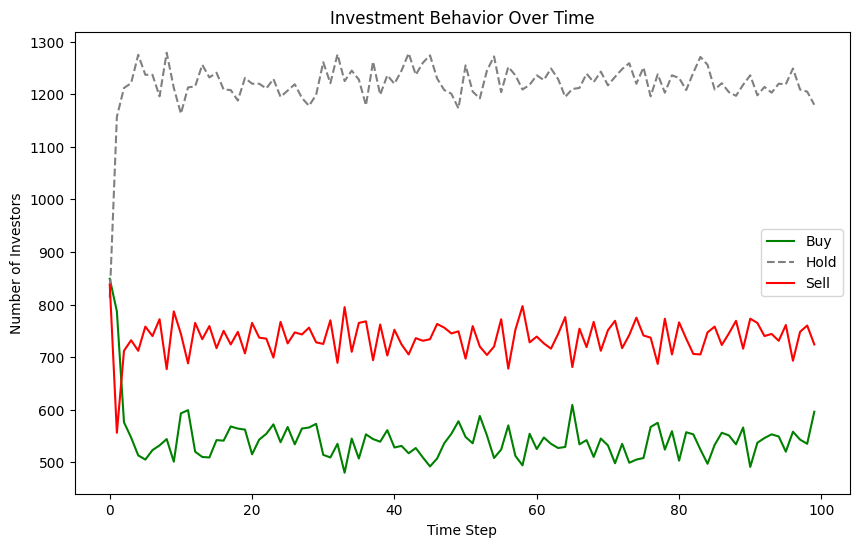

In [9]:
simulator = MarketSimulator2D_CA(grid_size=50)
simulator.create_random_grid()
simulator.plot_grid()

simulator.run_simulation(100, 0.5, 0.5, "negative")
simulator.plot_grid()
simulator.plot_hist()


In [ ]:
class MarketSimulator2D_CLA(MarketSimulator2D_CA):
    def __init__(self, grid_size, alpha, theta):
        super().__init__(grid_size)
        self.alpha = alpha
        self.theta = theta

        self.reliability_weights = np.ones((self.grid_size, self.grid_size, 8))

        self.prev_grid = None
        self.prev_dominant_count = 0
        self.prev_market_consensus = None

        self.history["macro_factor"] = []

        self.neighbor_map = [(i, j) for i in [-1, 0, 1] for j in [-1, 0, 1] if not (i == 0 and j == 0)]
    
    
    def get_valid_neighbors_with_indices(self, i, j):

        neighbors = []
        for idx, (di, dj) in enumerate(self.neighbor_map):
            ni, nj = i + di, j + dj

            if 0 <= ni < self.grid_size and 0 <= nj < self.grid_size:
                neighbors.append({'coord': (ni, nj), 'weight_idx': idx})

        return neighbors
    
    def get_greatest_reliability_behavior(self, grid, i, j):

        neighbor_info = self.get_valid_neighbors_with_indices(i, j)
        
        cell_weights = self.reliability_weights[i, j]

        buy_weight_sum = 0
        hold_weight_sum = 0
        sell_weight_sum = 0

        for neighbor in neighbor_info:
            ni, nj = neighbor['coord']
            weight_idx = neighbor['weight_idx']
            
            neighbor_state = grid[ni, nj]
            weight = cell_weights[weight_idx]
            
            if neighbor_state == self.BUY:
                buy_weight_sum += weight
            elif neighbor_state == self.HOLD:
                hold_weight_sum += weight
            elif neighbor_state == self.SELL:
                sell_weight_sum += weight

        sums_array = np.array([buy_weight_sum, hold_weight_sum, sell_weight_sum])
        max_sum = np.max(sums_array)
        tie_count = np.sum(sums_array == max_sum)
        
        if tie_count > 1:
            return self.HOLD
        else:
            winner_index = np.argmax(sums_array)
            return self.states_array[winner_index]

    
    def determine_momentum_C_t(self, current_dominant_count):
        delta_t = current_dominant_count-self.prev_dominant_count

        return 1+(delta_t/current_dominant_count)
    
    def chi_reward_penalty_sign(self, i,j): 
        rp_sign = None
        
        if self.prev_grid[i,j] == self.prev_market_consensus:
            rp_sign = 1
        elif self.prev_grid[i,j] == 0:
            rp_sign = -self.alpha
        else:
            rp_sign = -(1-self.alpha)
        
        return rp_sign

def calculate_all_rewards_penalties(self, prev_grid, current_grid):
    rp_matrix = np.zeros_like(self.reliability_weights)

    # --- 1. Analyze the two time steps to determine consensus and momentum ---
    prev_counts = {s: np.sum(prev_grid == s) for s in self.STATES}
    current_counts = {s: np.sum(current_grid == s) for s in self.STATES}

    if not any(prev_counts.values()): return rp_matrix # Grid is empty

    # The "correct" answer was the consensus from the PREVIOUS step
    t_max = max(prev_counts, key=prev_counts.get)
    
    # Calculate Ct based on the change in the dominant group
    # Note: This is a simplified Ct. The paper's logic is more complex.
    # Let's assume a simple momentum for now.
    prev_dominant_count = prev_counts[t_max]
    current_dominant_count = current_counts[t_max]
    if prev_dominant_count == 0:
        ct = 1.0
    else:
        delta_t = current_dominant_count - prev_dominant_count
        ct = 1.0 + (delta_t / prev_dominant_count)

    # --- 2. Loop through each cell 'x' to calculate RP for its neighbors ---
    for i in range(self.grid_size):
        for j in range(self.grid_size):
            # For cell (i,j), we evaluate the advice its neighbors gave in prev_grid
            neighbor_info = self.get_valid_neighbors_with_indices(i, j)
            if not neighbor_info: continue
            
            num_neighbors = len(neighbor_info)
            
            # First, get local counts from the PREVIOUS grid
            local_prev_counts = {s: 0 for s in self.STATES}
            for neighbor in neighbor_info:
                ni, nj = neighbor['coord']
                local_prev_counts[prev_grid[ni, nj]] += 1
            
            n_x_t_max = local_prev_counts[t_max]

            # Now, for each neighbor of (i,j), calculate its individual RP
            for neighbor in neighbor_info:
                ni, nj = neighbor['coord']
                weight_idx = neighbor['weight_idx']
                
                neighbor_prev_state = prev_grid[ni, nj]
                
                # Calculate Chi (the sign of the reward/penalty)
                if neighbor_prev_state == t_max:
                    chi = 1
                elif neighbor_prev_state == self.HOLD:
                    chi = -self.alpha
                else:
                    chi = -(1 - self.alpha)
                
                # Calculate the fraction part of the formula
                n_x_neighbor_prev_state = local_prev_counts[neighbor_prev_state]
                if n_x_neighbor_prev_state == 0:
                    fraction = 0
                else:
                    denominator = num_neighbors * n_x_neighbor_prev_state
                    fraction = (num_neighbors - n_x_t_max) / denominator
                
                rp = chi * ct * self.theta * fraction
                rp_matrix[i, j, weight_idx] = rp
                
    return rp_matrix

def update_grid(self, current_grid, P, mf_volatility):

    random_step = np.random.normal(loc=0.0, scale= mf_volatility)
    Mf = self.history["macro_factor"][-1]+ random_step
    self.history["macro_factor"].append(Mf)

    rp_matrix = self.calculate_all_rewards_penalties(current_grid)
    self.reliability_weights += rp_matrix

    np.clip(self.reliability_weights, 0.1, 10, out=self.reliability_weights)

    new_grid = np.zeros_like(current_grid)
    for i in range(self.grid_size):
        for j in range(self.grid_size):
            gb = self.get_greatest_reliability_behavior(current_grid, i, j)

            macro_info = "positive" if Mf > 0 else "negative" if Mf < 0 else "none"
            
            probs = self.get_transition_probabilities(gb, P, Mf, macro_info)            
            new_grid[i, j] = np.random.choice(self.STATES, p=probs)
            
    return new_grid

def run_simulation(self, num_steps, P, initial_mf=0.0, mf_volatility=0.05):
    # --- SETUP ---
    self.history = {"buy": [], "hold": [], "sell": [], "macro_factor": []}
    self.reliability_weights.fill(1.0) # Reset weights to 1 for each run
    
    mf_current = initial_mf
    grid = self.grid.copy()
    prev_grid = grid.copy() # Start with prev_grid = grid

    # --- MAIN LOOP ---
    for step in range(num_steps):
        # --- 1. STORE HISTORY (for the state at the beginning of the step) ---
        self.history["buy"].append(np.sum(grid == self.BUY))
        self.history["hold"].append(np.sum(grid == self.HOLD))
        self.history["sell"].append(np.sum(grid == self.SELL))
        self.history["macro_factor"].append(mf_current)

        if step > 0:
            rp_matrix = self.calculate_all_rewards_penalties(prev_grid, grid)
            self.reliability_weights += rp_matrix
            np.clip(self.reliability_weights, 0.1, 10, out=self.reliability_weights)

        random_step = np.random.normal(loc=0.0, scale=mf_volatility)
        mf_current += random_step
        mf_current = np.clip(mf_current, -0.5, 0.5)
    
        # The current grid becomes the previous grid for the next iteration
        prev_grid = grid.copy() 
        
        # --- 4. DECIDE (calculate the new grid state) ---
        grid = self.update_grid(grid, P, mf_current)

    self.grid = grid
